# BENCHMARK: 

- Train RMSE: 3_448
- Validation RMSE: 3_049

# Imports:

In [361]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from functools import partial
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline

from numba import njit
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer
from window_ops.rolling import rolling_mean
from xgboost import XGBRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

# MLForecast_Evaluator class definition for models evaluation and prediction:

In [362]:
class MLForecast_Evaluator:
    def __init__(self, fcst, valid, future_df, h=1):
        self.fcst = fcst
        self.valid = valid
        self.future_df = future_df
        self.h = h
        self.mean_rmse_valid = None # To use for filename (mean rmse of all models)
        
        # Generate predictions
        self.predictions = fcst.predict(h=self.h, X_df=future_df)
        
        # Merge predictions with valid set
        self.results = valid.merge(self.predictions, on=['unique_id', 'ds'])
        
        # Get fitted values (train predictions)
        self.train_preds = fcst.forecast_fitted_values()
        
        # Identify model columns
        self.model_columns = list(fcst.models.keys())
        
    def plot_time_series(self, n_samples: int = 4, figsize: tuple = None, random_state: Optional[int] = None):
        """
        Plots the time series for a random sample of unique_ids.
        
        Parameters
        ----------
        """
        
        # Sample random unique_ids
        unique_ids = self.train_preds['unique_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=min(n_samples, len(unique_ids)), replace=False)
        
        # Calculate grid dimensions
        n_cols = math.ceil(math.sqrt(n_samples))
        n_rows = math.ceil(n_samples / n_cols)
        
        # Calculate adaptive figsize if not provided
        if figsize is None:
            figsize = (7 * n_cols, 4 * n_rows)
        
        # Create subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle('Time Series Visualization', fontsize=16)

        axs = axs.flatten() if n_samples > 1 else [axs]

        # List to store handles and labels for the legend
        handles, labels = [], []

        for i, unique_id in enumerate(sampled_ids):
            train_data = self.train_preds[self.train_preds['unique_id'] == unique_id]
            valid_data = self.results[self.results['unique_id'] == unique_id]

            # Plot train data
            h_train, = axs[i].plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='black')
            if 'Actual (Train)' not in labels:
                handles.append(h_train)
                labels.append('Actual (Train)')

            for model in self.model_columns:
                h_model_train, = axs[i].plot(train_data['ds'], train_data[model], label=f'{model} (Train)')
                if f'{model} (Train)' not in labels:
                    handles.append(h_model_train)
                    labels.append(f'{model} (Train)')
            
            # Plot valid data
            h_valid, = axs[i].plot(valid_data['ds'], valid_data['y'], label='Actual (Valid)', color='red', linestyle='--')
            if 'Actual (Valid)' not in labels:
                handles.append(h_valid)
                labels.append('Actual (Valid)')

            for model in self.model_columns:
                h_model_valid = axs[i].scatter(valid_data['ds'], valid_data[model], label=f'{model} (Valid)')
                if f'{model} (Valid)' not in labels:
                    handles.append(h_model_valid)
                    labels.append(f'{model} (Valid)')

            axs[i].set_title(f'Time Series - ID: {unique_id}')
            axs[i].set_xlabel('Date')
            axs[i].set_ylabel('Value')
        
        # Remove any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        
        # Add a single legend for all subplots
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=len(self.model_columns) + 2, fontsize='small')
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
        plt.show()

    def calculate_metrics(self) -> pd.DataFrame:
        metrics = {}

        for model in self.model_columns:
            model_metrics = {}
            for result_df, name in zip([self.train_preds, self.results], ['train', 'valid']):
                y_true = result_df['y']
                y_pred = result_df[model]

                model_metrics[f'RMSE_{name}'] = np.sqrt(mean_squared_error(y_true, y_pred))
                model_metrics[f'R2_{name}'] = r2_score(y_true, y_pred)

            metrics[model] = model_metrics

        metrics_df = pd.DataFrame(metrics).T

        # Find the model with the lowest validation RMSE
        lowest_rmse_model = metrics_df['RMSE_valid'].idxmin()
        lowest_rmse_value = metrics_df.loc[lowest_rmse_model, 'RMSE_valid']
        
        self.mean_rmse_valid = metrics_df['RMSE_valid'].mean()  # Calculate and store mean RMSE for submission

        print(f"MEAN RMSE_VALID = {self.mean_rmse_valid}\n")
        print(f"Model with lowest RMSE validation is {lowest_rmse_model} with RMSE = {lowest_rmse_value}\n")
        print(metrics_df.sort_values(by='RMSE_valid'))

        return metrics_df.sort_values(by='RMSE_valid')
    
    def plot_feature_importances(self):
        # Initialize an empty DataFrame to store the feature importances
        df = pd.DataFrame()

        # Loop through each model to get its feature importances
        for model in self.model_columns:
            feature_importances = self.fcst.models_[model].feature_importances_
            feature_names = self.fcst.ts.features_order_

            # Create a temporary DataFrame for the current model
            temp_df = pd.DataFrame(feature_importances, columns=[model], index=feature_names)

            # Merge the temporary DataFrame with the main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')

        # Fill NaNs with 0 (if any feature is missing in some models)
        df = df.fillna(0)
        # Scale the feature importances between 0 and 1 for each model
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

        # Sort features by their average importance
        average_importance = df_scaled.mean(axis=1)
        sorted_features = average_importance.sort_values(ascending=True).index[-50:]

        # Reorder DataFrame according to the sorted feature list
        df_scaled = df_scaled.loc[sorted_features]

        # Plotting the horizontal multi-bar plot
        fig, ax = plt.subplots(figsize=(10, 15))

        # Define the height of the bars and the positions for each group
        bar_height = 0.15
        index = np.arange(len(sorted_features))

        # Loop through each model and plot its feature importances
        for i, model in enumerate(self.model_columns):
            ax.barh(index + i * bar_height, df_scaled[model], bar_height, label=model)

        # Add labels, title, and legend
        ax.set_ylabel('Feature')
        ax.set_xlabel('Scaled Importance')
        ax.set_title('Scaled Feature Importances by Model')
        ax.set_yticks(index + bar_height * (len(self.model_columns) - 1) / 2)
        ax.set_yticklabels(sorted_features)
        ax.legend()

        plt.tight_layout()
        plt.show()


    def plot_metrics(self):
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot 1: Scatter plot of predicted vs actual values
        for model in self.model_columns:
            # Scatter plot
            sns.scatterplot(x=self.results[model], y=self.results['y'], label=model, ax=ax1, alpha=0.7)
            
            # Fit line
            X = self.results[model].values.reshape(-1, 1)
            y = self.results['y'].values
            reg = LinearRegression().fit(X, y)
            ax1.plot(X, reg.predict(X))

        # Plot the perfect prediction line
        min_val = min(self.results['y'].min(), self.results[self.model_columns].min().min())
        max_val = max(self.results['y'].max(), self.results[self.model_columns].max().max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')

        ax1.set_xlabel('Predicted Value')
        ax1.set_ylabel('Actual Value')
        ax1.set_title('Validation Set: Predicted vs Actual')
        ax1.legend(title='Model')

        # Plot 2: Distribution of Residuals
        scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
        palette = sns.color_palette(n_colors=len(self.model_columns))
        
        for i, model in enumerate(self.model_columns):
            # Calculate residuals
            residuals = self.results['y'] - self.results[model]
            
            # Remove infinite values and extreme outliers
            mask = np.isfinite(residuals) & (np.abs(residuals) < np.percentile(np.abs(residuals), 99))
            clean_residuals = residuals[mask]
            
            if len(clean_residuals) > 0:
                # Scale the residuals
                residuals_scaled = scaler.fit_transform(clean_residuals.values.reshape(-1, 1)).flatten()
                
                # Plot KDE with increased bandwidth
                #sns.kdeplot(residuals_scaled, label=model, ax=ax2, bw_adjust=1.5, color=palette[i])
                sns.histplot(residuals_scaled, bins=30, label=model, kde=False, color=palette[i], alpha=0.5, ax=ax2)
                
                # Add rug plot
                #sns.rugplot(residuals_scaled, ax=ax2, color=palette[i], alpha=0.7)
            else:
                print(f"Warning: No valid residuals for model {model}")

        ax2.set_title('Distribution of Scaled Residuals')
        ax2.set_xlabel('Scaled Residual')
        ax2.set_ylabel('Density')
        ax2.legend(title='Model', fontsize=16) #change legend size
        
        # Set x-axis limits for better visibility
        ax2.set_xlim(-5, 5)

        plt.tight_layout()
        plt.show()


    def predict_save_submission(self, model_name, test_index):
        
        if model_name not in self.model_columns:
            raise ValueError(f"Model '{model_name}' not found. Available models are: {', '.join(self.model_columns)}")

        test_preds = self.predictions[self.predictions['ds'].isin(test_index)] #Test index was defined in split
        test_preds = test_preds[['unique_id', model_name]]
        
        # Rename the model column to 'monthly_sales'
        test_preds.rename(columns={model_name: 'monthly_sales'}, inplace=True)

        # Get today's date for the filename
        today = date.today()

        if self.mean_rmse_valid is None:
            print("Warning: mean_rmse_valid has not been calculated yet. Using 'unknown' in filename.")
            mean_rmse_str = "unknown"
        else:
            mean_rmse_str = f"{self.mean_rmse_valid:.4f}"  # Format to 4 decimal places

        output_filename = f"submissions\submission_{model_name}_mean_valid_RMSE_{mean_rmse_str}_{today}.csv"
        test_preds.to_csv(output_filename, index=False)

        print(f"Submission file '{output_filename}' has been created successfully.")

        return test_preds

# Data Load:

In [363]:
path = r'.\data\ts_kaggle_train.csv'
data = pd.read_csv(path, index_col=0, parse_dates=['date'])

In [364]:
data.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [365]:
data.tail()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
14479,2015-10-31,7_5822,21,7,35,5822,NaN,NaN
14480,2015-10-31,7_6185,21,7,30,6185,NaN,NaN
14481,2015-10-31,7_6497,21,7,28,6497,NaN,NaN
14482,2015-10-31,7_7856,21,7,28,7856,NaN,NaN
14483,2015-10-31,7_7893,21,7,6,7893,NaN,NaN


### Transform to MLforecast nomenclature and save columns in useful lists:

In [366]:
# target = y
data.rename(columns={'date': 'ds', 'monthly_sales': 'y'}, inplace=True)

In [367]:
core_features = ['ds','unique_id']
static_features = ['city_id', 'shop_id', 'item_category_id', 'item_id']

# EDA

In [368]:
data["unique_id"].nunique() # we have 426 unique_ids = 426 time series

426

In [369]:
print(f"Min date is {data["ds"].min()}\nMax date is {data["ds"].max()}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [370]:
#data.isnull().sum()

In [371]:
#data['y'].hist(bins=30);
#plt.title("Target distribution in data");

In [372]:
#data['ds'].dt.month.hist(bins=12);
#plt.title("Months distribution in data");

In [373]:
"""
fig = plt.figure(figsize = (12, 10))
ax1, ax2 = fig.subplots(2, 1)

sns.lineplot(data = data, x = "ds", y = "y", ax=ax1); # Accumulated monthly sales for all unique_ids
plt.xticks(rotation=45);
ax1.set_title("Accumulated monthly sales for all unique_ids");

sns.lineplot(data = data, x = "ds", y = data['y'].diff(), ax=ax2, label='Diff');
plt.xticks(rotation=45);
ax2.set_title("Differences in monthly sales for all unique_ids");

sns.lineplot(data = data, x = "ds", y = data['y'].apply(np.log1p).diff(), ax=ax2, label='Log Diff');
plt.xticks(rotation=45);
ax2.legend()
"""

'\nfig = plt.figure(figsize = (12, 10))\nax1, ax2 = fig.subplots(2, 1)\n\nsns.lineplot(data = data, x = "ds", y = "y", ax=ax1); # Accumulated monthly sales for all unique_ids\nplt.xticks(rotation=45);\nax1.set_title("Accumulated monthly sales for all unique_ids");\n\nsns.lineplot(data = data, x = "ds", y = data[\'y\'].diff(), ax=ax2, label=\'Diff\');\nplt.xticks(rotation=45);\nax2.set_title("Differences in monthly sales for all unique_ids");\n\nsns.lineplot(data = data, x = "ds", y = data[\'y\'].apply(np.log1p).diff(), ax=ax2, label=\'Log Diff\');\nplt.xticks(rotation=45);\nax2.legend()\n'

In [374]:
# sample 10 unique_ids to plot
"""
sample_ids = random.sample(list(data["unique_id"].unique()), 5)
sns.lineplot(data = data[data['unique_id'].isin(sample_ids)], x = "ds", 
             y = "y", hue = "unique_id", legend = True);
plt.xticks(rotation=45);
"""

'\nsample_ids = random.sample(list(data["unique_id"].unique()), 5)\nsns.lineplot(data = data[data[\'unique_id\'].isin(sample_ids)], x = "ds", \n             y = "y", hue = "unique_id", legend = True);\nplt.xticks(rotation=45);\n'

In [375]:
#data[data['item_id'] == 20949]

Iterating with previous plot I observed that item 20949 has a quite constant pattern, which could be detrimental to our models

In [376]:
# Plot item 20949 or 492 sales
"""
fig = plt.figure(figsize = (10, 10))
ax1, ax2 = fig.subplots(2, 1)

temp_df = data[data['item_id'] == 492]
#temp_df = data[data['item_id'] == 20949]

sns.lineplot(data = temp_df, x = "ds", y = "y", ax=ax1); # Accumulated monthly sales for item 20949
plt.xticks(rotation=45);
ax1.set_title("Accumulated monthly sales for item xx");

sns.lineplot(data = temp_df, x = "ds", y = data['y'].diff(), ax=ax2, label='Diff');
plt.xticks(rotation=45);
ax2.set_title("Differences in monthly sales for item xx");

sns.lineplot(data = temp_df, x = "ds", y = data['y'].apply(np.log1p).diff(), ax=ax2, label='Log Diff');
plt.xticks(rotation=45);
ax2.legend()
"""

'\nfig = plt.figure(figsize = (10, 10))\nax1, ax2 = fig.subplots(2, 1)\n\ntemp_df = data[data[\'item_id\'] == 492]\n#temp_df = data[data[\'item_id\'] == 20949]\n\nsns.lineplot(data = temp_df, x = "ds", y = "y", ax=ax1); # Accumulated monthly sales for item 20949\nplt.xticks(rotation=45);\nax1.set_title("Accumulated monthly sales for item xx");\n\nsns.lineplot(data = temp_df, x = "ds", y = data[\'y\'].diff(), ax=ax2, label=\'Diff\');\nplt.xticks(rotation=45);\nax2.set_title("Differences in monthly sales for item xx");\n\nsns.lineplot(data = temp_df, x = "ds", y = data[\'y\'].apply(np.log1p).diff(), ax=ax2, label=\'Log Diff\');\nplt.xticks(rotation=45);\nax2.legend()\n'

# NaN imputation:

- First test:
    - Imput target with 0 (NaN means no sales)
    - Imput monthly_average_price with fill with previous value (bfill) and next value (ffill)

- Second test: KNNimputer

In [377]:
"""pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="y").isnull()

sns.heatmap(pivot_df)"""

'pivot_df = data.pivot_table(\n    index = "ds", \n    columns="unique_id", \n    values="y").isnull()\n\nsns.heatmap(pivot_df)'

In [378]:
"""pivot_df = data.pivot_table(
    index = "ds", 
    columns="unique_id", 
    values="monthly_average_price").isnull()

sns.heatmap(pivot_df)"""

'pivot_df = data.pivot_table(\n    index = "ds", \n    columns="unique_id", \n    values="monthly_average_price").isnull()\n\nsns.heatmap(pivot_df)'

### First test:

In [379]:
data.fillna({"y":0}, inplace = True)

data["monthly_average_price"] = data.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.bfill().ffill()
)

# Feature engineering:

Already created month, year, quarter, and christmas_month features

In [380]:
#Eze features
data['month'] = data['ds'].dt.month
data['year'] = data['ds'].dt.year
data['quarter'] = data['ds'].dt.quarter
data['around_Xmas'] = data['ds'].dt.month.isin([1,12]).astype(int)

In [381]:
data['std'] = data.groupby('unique_id')['y'].transform(np.std)
data['mean'] = data.groupby('unique_id')['y'].transform(np.mean)

### Revenue

In [382]:
data["revenue"] = (data["y"] * data["monthly_average_price"])

In [383]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):
    
    assert "ds" in df.columns.tolist(), "ds must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("ds")
        .groupby(gb_list)
        .resample("ME")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
        
    gb_df_[f"{new_name}_lag1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    
    gb_df_[f"{new_name}_lag2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_

In [384]:
GB_LIST = ["item_id"]
TARGET_COLUMN = "y"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = data,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_revenue_ = build_ts_vars(
    df = data,
    gb_list = ["item_id"],
    target_column = "revenue",
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

data = pd.merge(data, vars_ts_, on = ["ds", "item_id"], how = "left")
data = pd.merge(data, vars_revenue_, on = ["ds", "item_id"], how = "left")

Dropping columns that might cause target leakage item_id_y_sum
Dropping columns that might cause target leakage item_id_revenue_sum


# Train, Validation, Test Split & Future dataset creation:

Future_df incorporates all exogenous dynamic features and is passed before prediction.

In [386]:
train_index = sorted(list(data["ds"].unique()))[:-2]
valid_index = [sorted(list(data["ds"].unique()))[-2]]
test_index = [sorted(list(data["ds"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valid_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



**Drop Revenue cause of leakage**

In [387]:
data.drop('revenue', axis=1, inplace=True)

In [388]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
test = data.loc[data['ds'].isin(test_index)]

In [389]:
future_df = data.drop('y', axis=1)
future_df.head()

,ds,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,month,year,quarter,around_Xmas,std,mean,item_id_y_sum_lag1,item_id_y_sum_lag2,item_id_revenue_sum_lag1,item_id_revenue_sum_lag2
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,1,2013,1,1,10.028658,19.823529,NaN,NaN,NaN,NaN
1,2013-01-31,12_11369,16,12,9,11369,572.715278,1,2013,1,1,6.075945,27.852941,NaN,NaN,NaN,NaN
2,2013-01-31,12_11370,16,12,9,11370,699.776786,1,2013,1,1,5.169843,29.000000,NaN,NaN,NaN,NaN
3,2013-01-31,12_11373,16,12,9,11373,548.900000,1,2013,1,1,9.569150,25.352941,NaN,NaN,NaN,NaN
4,2013-01-31,12_12231,16,12,49,12231,350.000000,1,2013,1,1,1.528109,2.294118,NaN,NaN,NaN,NaN


# MLforecast model creation:

## Models:

In [502]:
model = XGBRegressor(random_seed = 23, n_estimators = 100,
                        max_depth=5,       # Limit tree depth for simpler models (start with 3-5)
                        subsample=0.8,     # Use a subset of data for each tree (0.5-0.8)
                        reg_alpha=1,      # L1 regularization (encourages simpler models, 0-10)
                    )

## Target lags and transformations:

In [503]:
sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=model,
    freq='M',
    #target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    num_threads=2
)

### Save transformed data:

In [504]:
transform_data = fcst.preprocess(data, dropna=False)
#transform_data.to_csv(r'.\data\ts_kaggle_data_transformed.csv', index=False)

## Train and fit all models

In [505]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor], freq=M, lag_features=[], date_features=[], num_threads=2)

In [506]:
fcst.forecast_fitted_values()

,unique_id,ds,y,XGBRegressor
0,12_11365,2013-02-28,27.0,20.077730
1,12_11365,2013-03-31,30.0,25.115473
2,12_11365,2013-04-30,27.0,18.542175
3,12_11365,2013-05-31,30.0,21.664284
4,12_11365,2013-06-30,28.0,25.646431
...,...,...,...,...
13201,7_7893,2015-04-30,2.0,3.945580
13202,7_7893,2015-05-31,3.0,2.347681
13203,7_7893,2015-06-30,1.0,4.053314
13204,7_7893,2015-07-31,1.0,1.264752


# Evaluate on validation set (h=1)

MEAN RMSE_VALID = 3.6396462535008594

Model with lowest RMSE validation is XGBRegressor with RMSE = 3.6396462535008594

              RMSE_train  R2_train  RMSE_valid  R2_valid
XGBRegressor    3.818409  0.768571    3.639646  0.756642


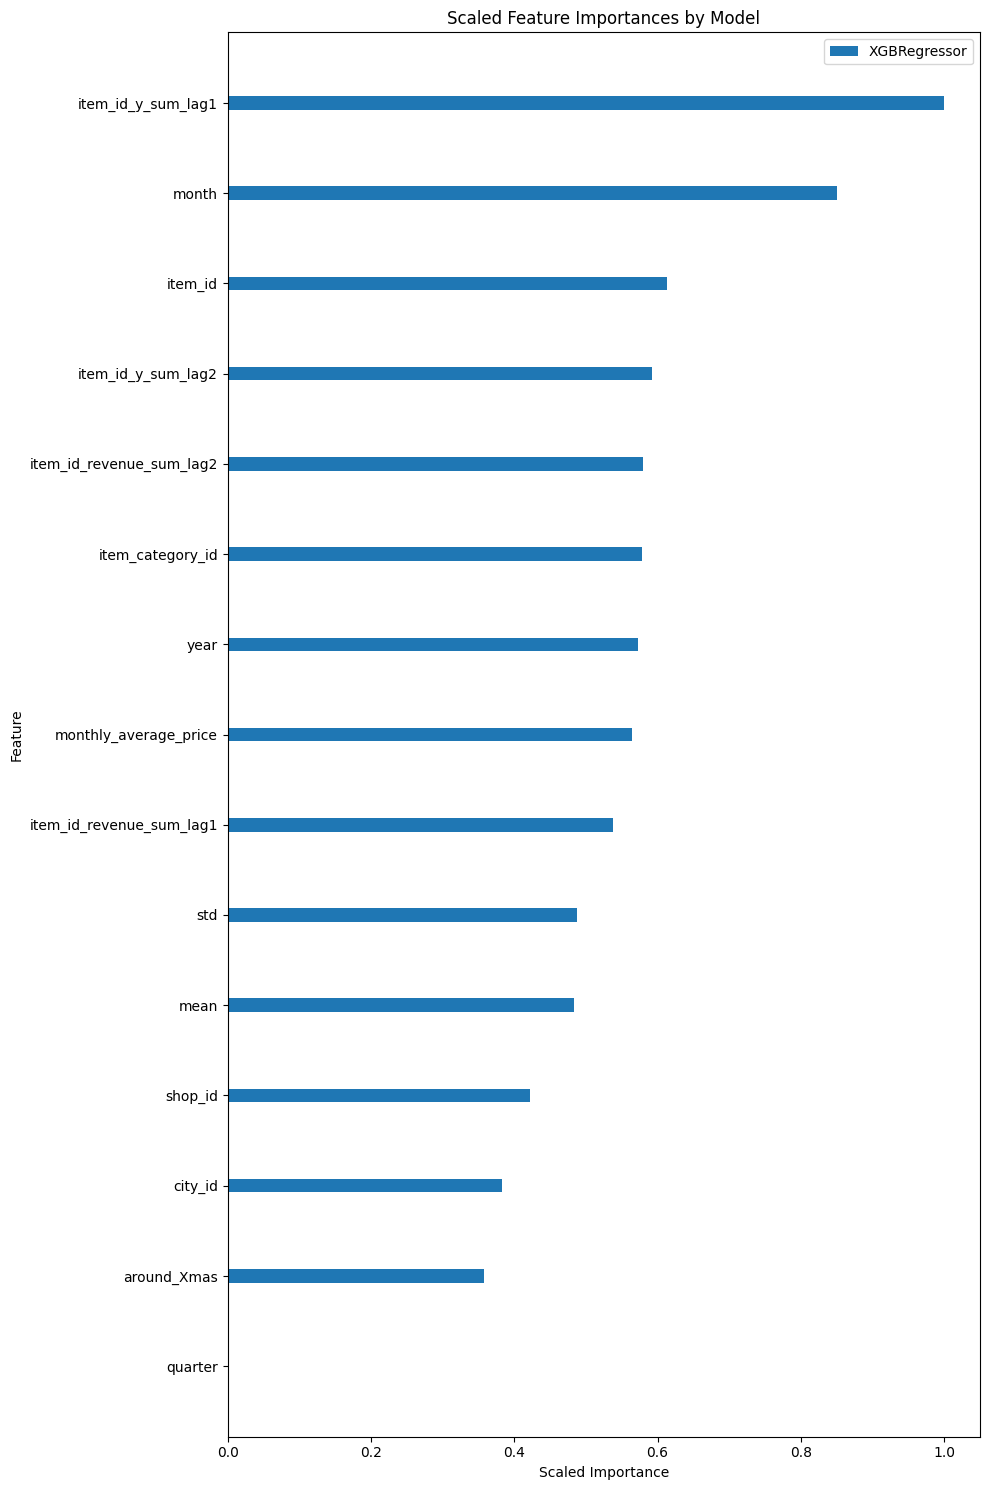

In [507]:
# Assuming you have your fcst object and valid set ready
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)

# Plot time series
#evaluator.plot_time_series(n_samples=6)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
#evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Predicting future values (test)

In [508]:
# Predict h=2 and save second prediction as submission
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=2)
evaluator.calculate_metrics()

#for model in evaluator.model_columns:
model = 'RandomForestRegressor'
#evaluator.predict_save_submission(model, test_index=test_index)

MEAN RMSE_VALID = 3.6396462535008594

Model with lowest RMSE validation is XGBRegressor with RMSE = 3.6396462535008594

              RMSE_train  R2_train  RMSE_valid  R2_valid
XGBRegressor    3.818409  0.768571    3.639646  0.756642


ValueError: Model 'RandomForestRegressor' not found. Available models are: XGBRegressor

# Predicting future values (test) with train+valid fit

In [ ]:
test_index = [sorted(list(data["ds"].unique()))[-1]]
train = data.loc[~data['ds'].isin(test_index)] #train is now all data except the last month
valid = data.loc[data['ds'].isin(valid_index)] #valid RMSE will be unrealistic but I need it for evaluator
test = data.loc[data['ds'].isin(test_index)]

all_features = list(train.columns)
dynamic_features = list(set(all_features) - set(static_features) - set('y'))

future_df = data[dynamic_features]

In [ ]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=static_features)

MLForecast(models=[RandomForestRegressor], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag6', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6', 'diff_lag1_lag1', 'diff_lag1_lag3', 'diff_lag1_lag6', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.2', 'rolling_mean_lag2_window_size3', 'rolling_mean_lag2_window_size6', 'expanding_mean_lag2', 'rolling_mean_lag3_window_size3', 'rolling_mean_lag3_window_size6', 'expanding_mean_lag3', 'rolling_mean_lag6_window_size3', 'expanding_mean_lag6', 'exponentially_weighted_mean_lag6_alpha0.2'], date_features=[], num_threads=6)

In [ ]:
# Predict h=2 and save second prediction as submission
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)
#evaluator.calculate_metrics()

#for model in evaluator.model_columns:
model = 'RandomForestRegressor'
evaluator.predict_save_submission(model, test_index=test_index)

Submission file 'submissions\submission_RandomForestRegressor_mean_valid_RMSE_unknown_2024-07-10.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,14.261923
1,12_11369,20.898990
2,12_11370,20.998151
3,12_11373,19.152462
4,12_12231,1.234744
...,...,...
421,7_5822,4.416912
422,7_6185,1.418024
423,7_6497,2.083720
424,7_7856,1.806759
